In [23]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from scipy import ndimage
from sklearn.model_selection import train_test_split

'''ImageCLEF2021 data preprocessor and loader'''

# Preprocessing functions
##############################################
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def hu_window(volume):
    """
    Preprocess the volume for lungs
    Copied from https://github.com/amorimdiogo/VNet/blob/master/preprocess.py
    """
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    # Normalize between 0 and 1
    img[img < 0] = 0
    img[img > 1] = 1
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Preprocess
    volume = hu_window(volume)
    # Resize width, height and depth & normalize to [0,1]
    volume = resize_volume(volume)
    return volume
##############################################


# Classes for data loading and preprocessing
class ImageCLEFDataset:
    def __init__(
            self, 
            datadir, 
            csv_path,
            flag,
    ):
        
        # Patient names in folder
        self.ids = sorted(os.listdir(datadir))
        #self.ids.remove('.DS_Store') # issue for Macs only
        
        # Sorted patient names in folder
        self.images_fps = [os.path.join(datadir, image_id) for image_id in self.ids]
        
        # Read csv path
        csv = pd.read_csv(os.path.join(csv_path))
        
        # Get labels
        self.labels = csv[["TypeOfTB"]].values[:5] # [:5] used for testing, will use whole data later
        
        assert len(self.labels) == len(self.images_fps), print("Should be same!")
        
        # Split data
        train_vols, test_vols, train_labels, test_labels = train_test_split(self.images_fps, self.labels, test_size=0.20, random_state=42)
        print("Training data:", len(train_vols))
        print("Validation data:", len(test_vols))
        
        self.train_vols = train_vols
        self.test_vols = test_vols
        self.train_labels = train_labels
        self.test_labels = test_labels
        
        if flag == "train":
            self.images_fps = self.train_vols
            self.labels = self.train_labels
            self.ids = self.train_vols
            
        else:
            self.images_fps = self.test_vols
            self.labels = self.test_labels
            self.ids = self.test_vols
        
        
    def __getitem__(self, i):
        
        # Read data
        img = process_scan(self.images_fps[i])
        img = np.moveaxis(img, -1, 0)
        img = np.expand_dims(img, axis=3)
        
        # Get labels
        gt = self.labels[i]
        # One-hot encode labeks
        gt = np.squeeze(np.eye(5)[gt.reshape(-1)])

        return img, gt
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [4]:
# Import libraries
import os, sys
sys.path.insert(0,"..") 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
#import nibabel as nib
import numpy as np

##from dataloader.dataloader import process_scan, ImageCLEFDataset, Dataloader

ROOT_DIR = os.path.abspath("E:/TBT Classification CSE499/")
DATASET_PATH = os.path.join(ROOT_DIR, "E:/TBT Classification CSE499/Master Dataset/")
print(os.listdir(DATASET_PATH))

['Dataset', 'labellingData.csv', 'Small Test Dataset', 'train-masks1', 'train-masks2']


In [5]:
def plot_seq(data, name):
    
    a, b = 3, 20
    data = np.reshape(data, (a, b, 128, 128))
    test_data = data
    r, c = test_data.shape[0], test_data.shape[1]

    cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

    heights = [a[0].shape[0] for a in test_data]
    widths = [a.shape[1] for a in test_data[0]]

    fig_width = 22.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
          gridspec_kw={'height_ratios':heights})

    for i in range(r):
        for j in range(c):
            axarr[i, j].imshow(test_data[i][j], cmap='gray')
            axarr[i, j].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    #plt.savefig('{}/{}.png'.format(log_path, name), dpi=200)
    plt.show()

In [6]:
dt = pd.read_csv(os.path.join(DATASET_PATH, 'labellingData.csv'))
dt.head()

,FileName,TypeOfTB
0,TRN_0001.nii.gz,1
1,TRN_0002.nii.gz,1
2,TRN_0003.nii.gz,1
3,TRN_0004.nii.gz,1
4,TRN_0005.nii.gz,1


In [7]:
# Labels
labels = dt[["TypeOfTB"]].values

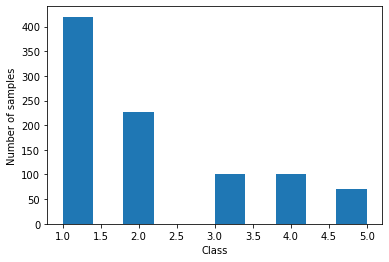

In [8]:
plt.hist(labels)
plt.ylabel("Number of samples")
plt.xlabel("Class")
plt.show()

In [9]:
len(labels)

917

In [10]:
labels.shape

(917, 1)

In [13]:
# Raw data path
subset_train_vols_path = os.path.join(DATASET_PATH, 'E:/TBT Classification CSE499/Master Dataset/Small Test Dataset/')
subset_train_vols = sorted(os.listdir(subset_train_vols_path))

##subset_train_vols.remove('.DS_Store')

len(subset_train_vols)
subset_train_vols[:5]

['TRN_0001.nii.gz',
 'TRN_0002.nii.gz',
 'TRN_0003.nii.gz',
 'TRN_0004.nii.gz',
 'TRN_0005.nii.gz']

In [14]:
count = 0
vol_path = os.path.join(subset_train_vols_path + subset_train_vols[0])
vol_path

'E:/TBT Classification CSE499/Master Dataset/Small Test Dataset/TRN_0001.nii.gz'

In [15]:
img = process_scan(vol_path)
img = np.moveaxis(img, -1, 0)
img = np.expand_dims(img, axis=3)
img.shape

(64, 128, 128, 1)

In [16]:
np.max(img), np.min(img)

(1.0, 0.0)

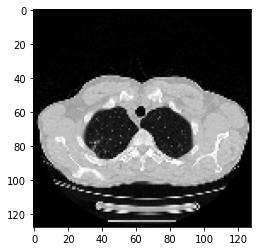

In [17]:
image = np.squeeze(img)
#plt.imshow(image[:,:,55], cmap='gray') # channels last
plt.imshow(image[55], cmap='gray') # channels first

In [18]:
dummy = image[:60]
dummy.shape

(60, 128, 128)

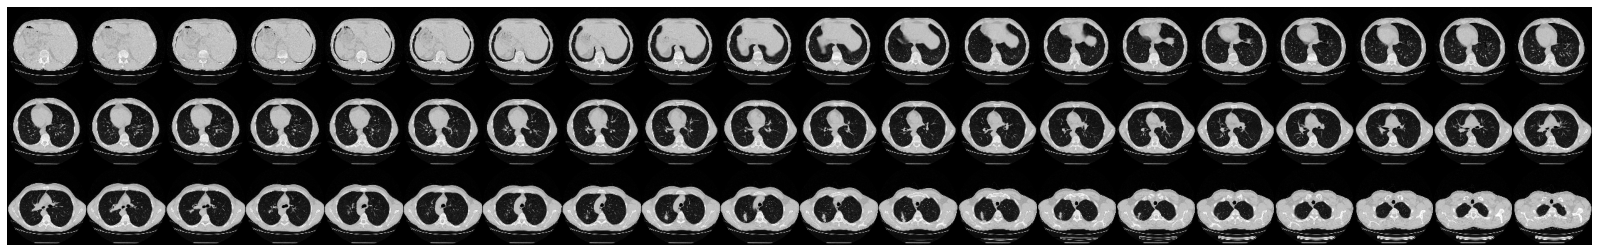

In [19]:
plot_seq(dummy, "full")

In [24]:
# ct data path, csv file path
train_dataset = ImageCLEFDataset(DATASET_PATH+ '/Small Test Dataset/',
                           DATASET_PATH + 'labellingData.csv', flag="train")

Should be same!


AssertionError: None